In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pyhepmc
import itertools
import math
import uproot 


# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])

# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 12, 6
mpl.rcParams['figure.dpi'] = 200

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

def fix_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    return ax

In [23]:
#Useful constants
tm15fm2_to_nb = 1.e-8
tm38cm2_to_nb = 1.
GeVm2_to_nb = 389379.09

#GENIE total cross section
genie_xsec = 4.85333e-05 #nb refactored code
noah_xsec =  4.936716e-05#nb
achilles_xsec = 6.08636e-05 #nb

genie_numevents = 400000
noah_numevents = 100000
achilles_numevents = 400000

In [8]:
#QE prediction from theory code
pred18 =  pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/CC/inclusive_theory_xsec/test_xsec_diff_nu_1000_18p0_CC.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred18.columns = ['w','sig']

pred25 =  pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/CC/inclusive_theory_xsec/test_xsec_diff_nu_1000_25p0_CC.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred25.columns = ['w','sig']

pred30 =  pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/CC/inclusive_theory_xsec/test_xsec_diff_nu_1000_30p0_CC.out',sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
pred30.columns = ['w','sig']

pred = [pred18,pred25,pred30]



In [43]:
#Get Noah's events

probe_p4 = []
lepton_p4 = []
innuc_p4 = []
outnuc_p4 = []

with open('test.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        probe_p4.append(p1)
        lepton_p4.append(p2)
        innuc_p4.append(p3)
        outnuc_p4.append(p4)
        

In [5]:
#Get achilles events

Ac_probe_p4 = []
Ac_lepton_p4 = []
Ac_proton_p4 = []
Ac_neutron_p4 = []

with pyhepmc.open("/Users/noah/Physics/Fermilab/Achilles/build/numu_1000.hepmc") as f:
    for event in f:
        if np.sqrt(event.particles[5].momentum.e**2 - event.particles[5].momentum.m()**2) < 221.:
            continue
        for p in event.particles:
            if p.pid == 13 and p.status == 1:
                Ac_lepton_p4.append(np.array([p.momentum.e, p.momentum.px, p.momentum.py, p.momentum.pz]))
            if p.pid == 2212 and p.status == 1:
                Ac_proton_p4.append(np.array([p.momentum.e, p.momentum.px, p.momentum.py, p.momentum.pz]))
            if p.pid == 14 and p.status == 4 and p.momentum.e == 1.0e3:
                Ac_probe_p4.append(np.array([p.momentum.e, p.momentum.px, p.momentum.py, p.momentum.pz]))  
            if p.pid == 2112 and p.status == 3:
                Ac_neutron_p4.append(np.array([p.momentum.e, p.momentum.px, p.momentum.py, p.momentum.pz]))
                


In [5]:
#Get GENIE events

genie_file = uproot.open("/Users/noah/Desktop/SF_C12_1GeV_Kelly_Refact.gst.root")
gst = genie_file["gst"]
branches = gst.arrays()
genie_probe_p4 = np.transpose([branches['Ev'],branches['pxv'], branches['pyv'], branches['pzv']])*1.e3
genie_lepton_p4 = np.transpose([branches['El'],branches['pxl'], branches['pyl'], branches['pzl']])*1.e3
genie_neutron_p4 = np.transpose([branches['En'],branches['pxn'], branches['pyn'], branches['pzn']])*1.e3
genie_proton_p4 = np.transpose([branches['Ei'][branches['pdgi'] == 2212],branches['pxi'][branches['pdgi'] == 2212], branches['pyi'][branches['pdgi'] == 2212], branches['pzi'][branches['pdgi'] == 2212]])*1.e3

In [5]:
def get_double_diff_xsec(probeP4, leptonP4, angles, delta, xsec, events, bins, low_bins, high_bins):
    
    double_dif_angles = []
    weights = []
    
    for angle,low_bin,high_bin in zip(angles,low_bins,high_bins):
        double_dif = []

        high_cos = math.cos((angle + delta)*np.pi/180)
        low_cos = math.cos((angle - delta)*np.pi/180)
        delta_cos = (low_cos - high_cos)

        for probe,lep in zip(probeP4, leptonP4):
            omega = probe[0] - lep[0]
            probe_3 = [probe[1], probe[2], probe[3]]
            lep_3 = [lep[1], lep[2], lep[3]]
            cos_theta = np.dot(lep_3,probe_3)/(np.sqrt(np.dot(lep_3,lep_3))*np.sqrt(np.dot(probe_3,probe_3)))
            if cos_theta < low_cos and cos_theta > high_cos:
                double_dif.append(omega)

        bin_width = delta_cos*(high_bin - low_bin)/bins

        double_dif = np.array(double_dif)
        double_dif_angles.append(double_dif)
        weight = (xsec)/events/bin_width
        weights.append(weight)
    
    return double_dif_angles,weights



In [44]:
numbins = 20
omegalows = [30,30,30]
omegahighs = [200,250,350]

dtheta = 2
angles = [18,25,30]

noah_dsig,noah_weights = get_double_diff_xsec(probe_p4, lepton_p4, angles, dtheta, noah_xsec, noah_numevents, numbins, omegalows, omegahighs)

#achilles_dsig,achilles_weights = get_double_diff_xsec(Ac_probe_p4, Ac_lepton_p4, angles, dtheta, achilles_xsec, achilles_numevents, numbins, omegalows, omegahighs)

#genie_dsig,genie_weights = get_double_diff_xsec(genie_probe_p4, genie_lepton_p4, angles, dtheta, genie_xsec, genie_numevents, numbins, omegalows, omegahighs)    

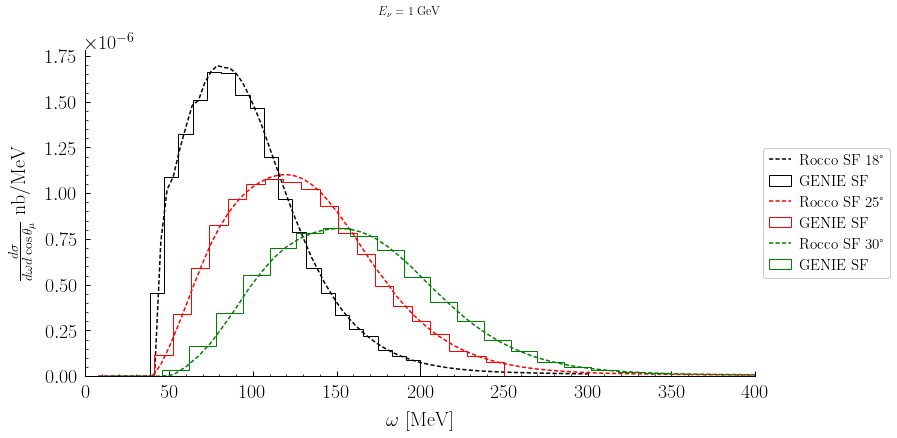

In [20]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
colors=['Black','Red','Green']
for i,angle in enumerate(angles):
    ax.plot(pred[i]['w'], pred[i]['sig']*tm15fm2_to_nb, label='Rocco SF %d\u00B0' %angle, color=colors[i], linestyle='--')
    
    ax.hist(genie_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(genie_dsig[i])*genie_weights[i],histtype='step',color=colors[i],label='GENIE SF')
      
ax.set_xlim(0, 400)
ax.set_xlabel(r'$\omega$ [MeV]')
ax = fix_ax(ax)
    
ax.set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')

ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV')
plt.show()

ax.legend()

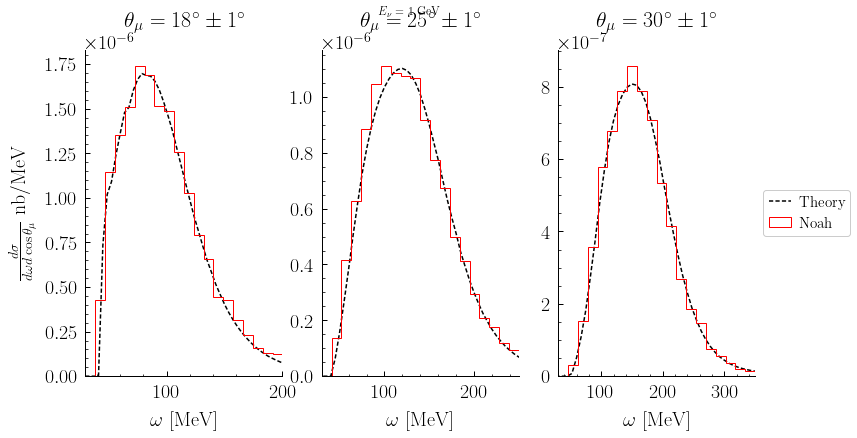

In [45]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i,angle in enumerate(angles):

    ax[i].plot(pred[i]['w'], pred[i]['sig']*tm15fm2_to_nb, label='Theory', color='black', linestyle='--')

    ax[i].hist(noah_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(noah_dsig[i])*noah_weights[i],histtype='step',color='red',label='Noah')

    #ax[i].hist(achilles_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(achilles_dsig[i])*achilles_weights[i],histtype='step',color='blue',label='Achilles')

    #ax[i].hist(genie_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(genie_dsig[i])*genie_weights[i],histtype='step',color='purple',label='GENIE')
      
    ax[i].set_xlim(omegalows[i],omegahighs[i])
    ax[i].set_xlabel(r'$\omega$ [MeV]')
    ax[i] = fix_ax(ax[i])
    
ax[0].set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].set_title(r'$\theta_{\mu} = {30}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV')
plt.show()

In [46]:
def get_transverse_proj(vec1,vec2):
    parallel_proj = np.dot(vec1,vec2) / np.linalg.norm(vec2) * (vec2/np.linalg.norm(vec2))
    
    trans_proj = vec1 - parallel_proj
    
    return trans_proj


def get_TKI_xsec(conversion,xsec, events, outnuc4, lep4, probe4, bin_alphaT, bin_PT, low_binalphaT, high_binalphaT, low_binPT, high_binPT):
    
    moms = []
    alphaT = []
    
    for nuc,lep,probe in zip(outnuc4,lep4,probe4):
        
        probe_mom = np.array([probe[1],probe[2],probe[3]])
        
        nuc_mom = np.array([nuc[1], nuc[2], nuc[3]])
        nuc_pt = get_transverse_proj(nuc_mom,probe_mom)

        lep_mom = np.array([lep[1], lep[2], lep[3]])
        lep_pt = get_transverse_proj(lep_mom,probe_mom)
        lep_pt_mag = np.linalg.norm(lep_pt)

        pt_mom = lep_pt + nuc_pt

        pt = np.linalg.norm(pt_mom)

        lepdotpt = np.dot(lep_mom,pt_mom)

        moms.append(pt)
        if np.abs(((-lepdotpt) / (lep_pt_mag * pt)) > 1.):
            print('shit')
        alphaT_val = math.acos( (-lepdotpt) / (lep_pt_mag * pt)) * 180./np.pi
        if alphaT_val > 180.:
            alphaT_val -= 180.
        if alphaT_val < 0.:
            alphaT_val += 180.

        alphaT.append(alphaT_val)
        
    TKI = [moms,alphaT]
        
    PTbin_width = (high_binPT - low_binPT)/bin_PT
    alphaTbin_width = (high_binalphaT - low_binalphaT)/bin_alphaT

    mom_weight = conversion*(xsec)/events/PTbin_width
    alphaT_weight = conversion*(xsec)/events/alphaTbin_width

    TKI_weight = [mom_weight, alphaT_weight]

    return TKI, TKI_weight


In [47]:
TKI, TKI_weight = get_TKI_xsec(1.,noah_xsec, noah_numevents, outnuc_p4,lepton_p4,probe_p4, 40, 40, 0, 180, 0, 800) 
#Ac_TKI, Ac_TKI_weight = get_TKI_xsec(1.,achilles_xsec, achilles_numevents,Ac_proton_p4,Ac_lepton_p4, Ac_probe_p4, 40, 40, 0, 180, 0, 800) 
#genie_TKI, genie_TKI_weight = get_TKI_xsec(1.,genie_xsec, genie_numevents,genie_proton_p4[0],genie_lepton_p4, genie_probe_p4, 40, 40, 0, 180, 0, 800)  
    

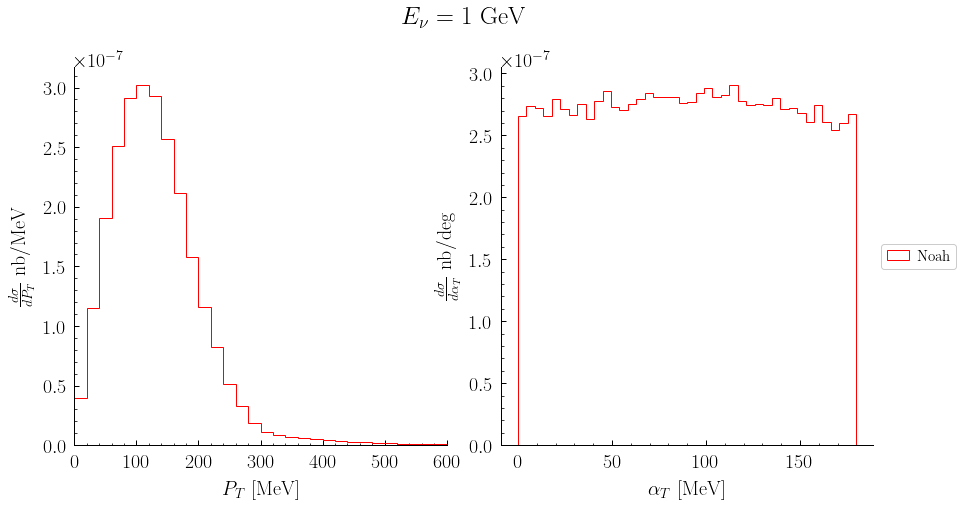

In [49]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(TKI[0], bins = 40, range = (0,800), weights = np.ones_like(TKI[0])*TKI_weight[0],histtype='step',label='Noah',color='red')

#ax[0].hist(Ac_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(Ac_TKI[0])*Ac_TKI_weight[0],histtype='step',label='Achilles')

#ax[0].hist(genie_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(genie_TKI[0])*genie_TKI_weight[0],histtype='step',label='Genie',color='purple')
ax[0].set_ylabel(r'$\frac{d\sigma}{dP_{T}}$ $\rm{nb}/\rm{MeV}$')
ax[0].set_xlabel(r'$P_{T}$ [MeV]')
ax[0].set_xlim([0,600])
#ax[0].set_yscale('log')

ax[0] = fix_ax(ax[0])


ax[1].hist(TKI[1], bins = 40, range = (0,180), weights = np.ones_like(TKI[1])*TKI_weight[1],histtype='step',label='Noah',color='red')
#ax[1].hist(Ac_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(Ac_TKI[1])*Ac_TKI_weight[1],histtype='step',label='Achilles')
#ax[1].hist(genie_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(genie_TKI[1])*genie_TKI_weight[1],histtype='step',label='Genie',color='purple')
ax[1].set_ylabel(r'$\frac{d\sigma}{d\alpha_{T}}$ $\rm{nb}/\rm{deg}$')
ax[1].set_xlabel(r'$\alpha_{T}$ [MeV]')

ax[1] = fix_ax(ax[1])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV',fontsize=25,y=1.1)
plt.show()


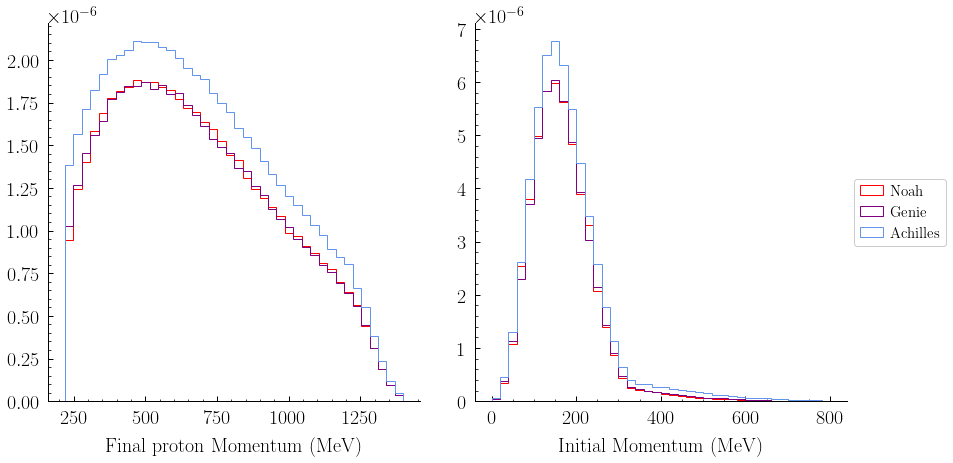

In [7]:
proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in outnuc_p4]
genie_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in genie_proton_p4[0]]
Ac_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ac_proton_p4]

neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in innuc_p4]
genie_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in genie_neutron_p4]
Ac_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ac_neutron_p4]

fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(proton_mom,bins = 40,range=(220,1400),weights = np.ones_like(proton_mom)*noah_xsec/noah_numevents,color='red',histtype='step',label='Noah')
ax[0].hist(genie_proton_mom,bins = 40,range=(220,1400),color='purple',histtype='step',weights = np.ones_like(genie_proton_mom)*genie_xsec/genie_numevents,label='Genie')
ax[0].hist(Ac_proton_mom,bins = 40,range=(220,1400),histtype='step',weights = np.ones_like(Ac_proton_mom)*achilles_xsec/achilles_numevents,label='Achilles')

ax[0] = fix_ax(ax[0])
#ax[0].set_yscale('log')

ax[1].hist(neutron_mom,bins = 40,range=(0,800),weights = np.ones_like(neutron_mom)*noah_xsec/noah_numevents,color='red',histtype='step',label='Noah')
ax[1].hist(genie_neutron_mom,bins = 40,range=(0,800),color='purple',histtype='step',weights = np.ones_like(genie_neutron_mom)*genie_xsec/genie_numevents,label='Genie')
ax[1].hist(Ac_neutron_mom,bins = 40,range=(0,800),histtype='step',weights = np.ones_like(Ac_neutron_mom)*achilles_xsec/achilles_numevents,label='Achilles')

ax[1] = fix_ax(ax[1])
#ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8,8e-6])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

ax[0].set_xlabel('Final proton Momentum (MeV)')
ax[1].set_xlabel('Initial Momentum (MeV)')
plt.show()



Noahs mean =  -14.267701593893241
Achilles mean =  -17.64681489372548
GENIE mean =  -15.704810453095687


Text(67.3043737352117, 0.5, '$\\frac{d\\sigma}{dP_{N_{L}}}$ [nb/MeV]')

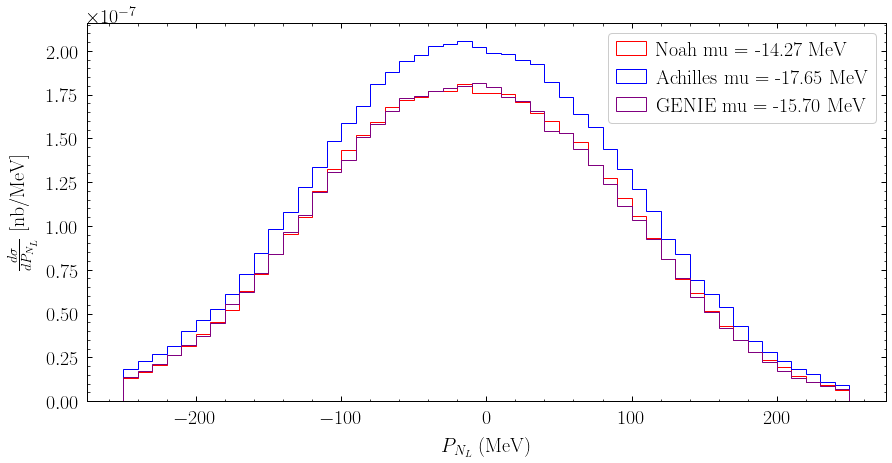

In [70]:
#Look at longitudinal nucleon momentum
#interesting we observe the same shift as https://arxiv.org/pdf/2310.15633.pdf
fig,ax = plt.subplots(1,1,figsize=(12,6))
fig.tight_layout()

from scipy.stats import norm

noah_long = parallel_mom(probe_p4,innuc_p4)
Ac_long = parallel_mom(Ac_probe_p4,Ac_neutron_p4)
genie_long = parallel_mom(genie_probe_p4,genie_neutron_p4)

noah_mean,noah_std=norm.fit(noah_long)
print('Noahs mean = ',noah_mean)
achilles_mean,noah_std=norm.fit(Ac_long)
print('Achilles mean = ',achilles_mean)
genie_mean,noah_std=norm.fit(genie_long)
print('GENIE mean = ',genie_mean)

ax.hist(noah_long, bins = 50, range = (-250,250), weights = np.ones_like(noah_long)*noah_xsec/noah_numevents/10.,histtype='step',label='Noah mu = {:.2f} MeV'.format(noah_mean),color='red')

ax.hist(Ac_long, bins = 50, range = (-250,250), weights = np.ones_like(Ac_long)*achilles_xsec/achilles_numevents/10.,histtype='step',label='Achilles mu = {:.2f} MeV'.format(achilles_mean),color='blue')

ax.hist(genie_long, bins = 50, range = (-250,250), weights = np.ones_like(genie_long)*genie_xsec/genie_numevents/10.,histtype='step',label='GENIE mu = {:.2f} MeV'.format(genie_mean),color='purple')

ax.legend()

ax.set_xlabel(r'$P_{N_{L}}$ (MeV)')
ax.set_ylabel(r'$\frac{d\sigma}{dP_{N_{L}}}$ [nb/MeV]')



In [33]:
def parallel_mom(probe_mom,nuc_mom):
    longmom = []
    
    for probe,nuc in zip(probe_mom, nuc_mom):
        longmom.append( np.dot( probe[1:4],nuc[1:4] )/np.sqrt( np.dot( probe[1:4],probe[1:4] ) ) )
        
    return longmom

In [62]:
#Now lets do comparison for Argon
Ar_probe_p4 = []
Ar_lepton_p4 = []
Ar_innuc_p4 = []
Ar_outnuc_p4 = []

with open('Ar40_CC_1000.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        Ar_probe_p4.append(p1)
        Ar_lepton_p4.append(p2)
        Ar_innuc_p4.append(p3)
        Ar_outnuc_p4.append(p4)

#total cross section
Ar_noah_xsec = 18.06e-05 #nb
Ar_noah_numevents = 400074          
        

In [39]:
#Get GENIE events

Ar_genie_file = uproot.open("/Users/noah/Desktop/numu_Ar40_1GeV.gst.root")
Ar_gst = Ar_genie_file["gst"]
Ar_branches = Ar_gst.arrays()
Ar_genie_probe_p4 = np.transpose([Ar_branches['Ev'],Ar_branches['pxv'], Ar_branches['pyv'], Ar_branches['pzv']])*1.e3
Ar_genie_lepton_p4 = np.transpose([Ar_branches['El'],Ar_branches['pxl'], Ar_branches['pyl'], Ar_branches['pzl']])*1.e3
Ar_genie_neutron_p4 = np.transpose([Ar_branches['En'],Ar_branches['pxn'], Ar_branches['pyn'], Ar_branches['pzn']])*1.e3
Ar_genie_proton_p4 = np.transpose([Ar_branches['Ei'][Ar_branches['pdgi'] == 2212],Ar_branches['pxi'][Ar_branches['pdgi'] == 2212], Ar_branches['pyi'][Ar_branches['pdgi'] == 2212], Ar_branches['pzi'][Ar_branches['pdgi'] == 2212]])*1.e3

#total cross section
Ar_genie_xsec = 18.1068e-05 #nb
Ar_genie_numevents = 400000  


In [63]:
numbins = 25
omegalows = [30,30,30]
omegahighs = [200,250,350]

dtheta = 2.0
angles = [18,25,30]

Ar_noah_dsig,Ar_noah_weights = get_double_diff_xsec(Ar_probe_p4, Ar_lepton_p4, angles, dtheta, Ar_noah_xsec, Ar_noah_numevents, numbins, omegalows, omegahighs)


Ar_genie_dsig,Ar_genie_weights = get_double_diff_xsec(Ar_genie_probe_p4, Ar_genie_lepton_p4, angles, dtheta, Ar_genie_xsec, Ar_genie_numevents, numbins, omegalows, omegahighs)    

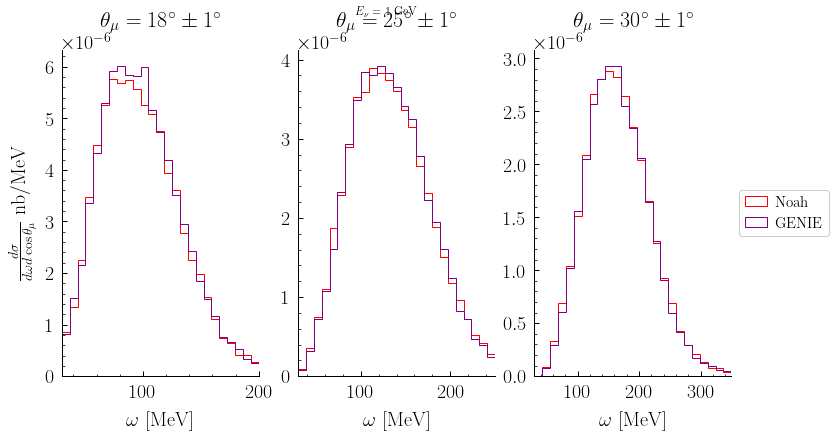

In [64]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i,angle in enumerate(angles):

    ax[i].hist(Ar_noah_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(Ar_noah_dsig[i])*Ar_noah_weights[i],histtype='step',color='red',label='Noah')

    ax[i].hist(Ar_genie_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(Ar_genie_dsig[i])*Ar_genie_weights[i],histtype='step',color='purple',label='GENIE')
      
    ax[i].set_xlim(omegalows[i],omegahighs[i])
    ax[i].set_xlabel(r'$\omega$ [MeV]')
    ax[i] = fix_ax(ax[i])
    
ax[0].set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].set_title(r'$\theta_{\mu} = {30}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV')
plt.show()

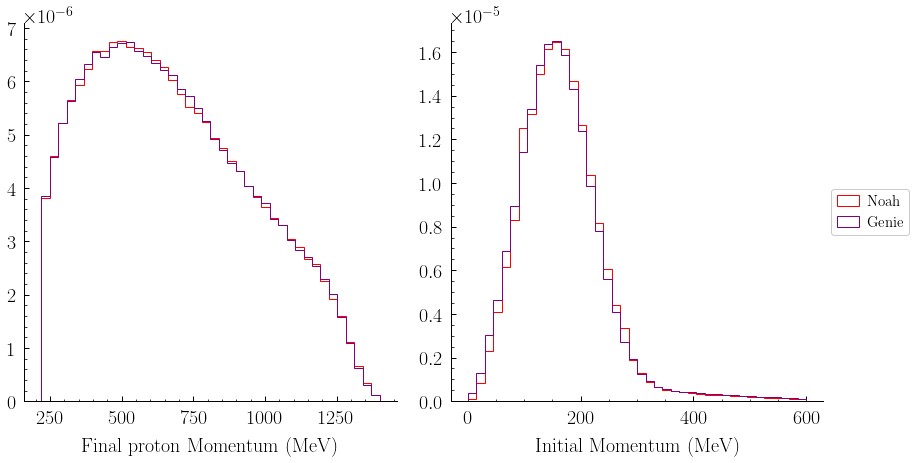

In [66]:
Ar_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_outnuc_p4]
Ar_genie_proton_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_genie_proton_p4[0]]

Ar_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_innuc_p4]
Ar_genie_neutron_mom = [np.sqrt(mom[1]**2 + mom[2]**2 + mom[3]**2) for mom in Ar_genie_neutron_p4]

fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(Ar_proton_mom,bins = 40,range=(220,1400),weights = np.ones_like(Ar_proton_mom)*Ar_noah_xsec/Ar_noah_numevents,color='red',histtype='step',label='Noah')
ax[0].hist(Ar_genie_proton_mom,bins = 40,range=(220,1400),color='purple',histtype='step',weights = np.ones_like(Ar_genie_proton_mom)*Ar_genie_xsec/Ar_genie_numevents,label='Genie')

ax[0] = fix_ax(ax[0])

ax[1].hist(Ar_neutron_mom,bins = 40,range=(0,600),weights = np.ones_like(Ar_neutron_mom)*Ar_noah_xsec/Ar_noah_numevents,color='red',histtype='step',label='Noah')
ax[1].hist(Ar_genie_neutron_mom,bins = 40,range=(0,600),color='purple',histtype='step',weights = np.ones_like(Ar_genie_neutron_mom)*Ar_genie_xsec/Ar_genie_numevents,label='Genie')

ax[1] = fix_ax(ax[1])
#ax[1].set_yscale('log')
#ax[1].set_ylim([1e-7,2.5e-5])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

ax[0].set_xlabel('Final proton Momentum (MeV)')
ax[1].set_xlabel('Initial Momentum (MeV)')
plt.show()

In [68]:
Ar_TKI, Ar_TKI_weight = get_TKI_xsec(1.,Ar_noah_xsec, Ar_noah_numevents, Ar_outnuc_p4,Ar_lepton_p4,Ar_probe_p4, 40, 40, 0, 180, 0, 800) 
Ar_genie_TKI, Ar_genie_TKI_weight = get_TKI_xsec(1.,Ar_genie_xsec, Ar_genie_numevents,Ar_genie_proton_p4[0],Ar_genie_lepton_p4, Ar_genie_probe_p4, 40, 40, 0, 180, 0, 800)  

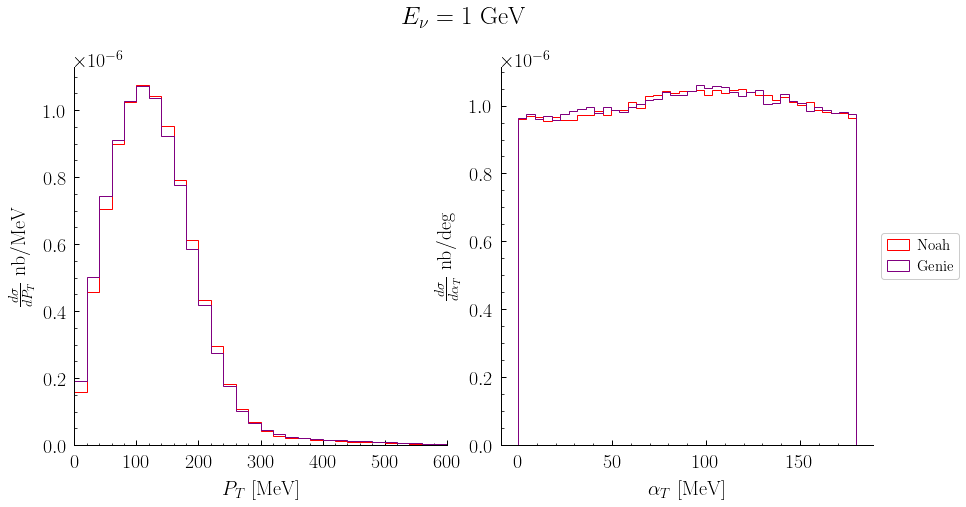

In [69]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

ax[0].hist(Ar_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(Ar_TKI[0])*Ar_TKI_weight[0],histtype='step',label='Noah',color='red')
ax[0].hist(Ar_genie_TKI[0], bins = 40, range = (0,800), weights = np.ones_like(Ar_genie_TKI[0])*Ar_genie_TKI_weight[0],histtype='step',label='Genie',color='purple')

ax[0].set_ylabel(r'$\frac{d\sigma}{dP_{T}}$ $\rm{nb}/\rm{MeV}$')
ax[0].set_xlabel(r'$P_{T}$ [MeV]')
ax[0].set_xlim([0,600])
ax[0] = fix_ax(ax[0])

ax[1].hist(Ar_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(Ar_TKI[1])*Ar_TKI_weight[1],histtype='step',label='Noah',color='red')
ax[1].hist(Ar_genie_TKI[1], bins = 40, range = (0,180), weights = np.ones_like(Ar_genie_TKI[1])*Ar_genie_TKI_weight[1],histtype='step',label='Genie',color='purple')
ax[1].set_ylabel(r'$\frac{d\sigma}{d\alpha_{T}}$ $\rm{nb}/\rm{deg}$')
ax[1].set_xlabel(r'$\alpha_{T}$ [MeV]')

ax[1] = fix_ax(ax[1])


ax[1].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 1$ GeV',fontsize=25,y=1.1)
plt.show()

In [123]:
#Now lets get flux folded events
flux_probe_p4 = []
flux_lepton_p4 = []
flux_innuc_p4 = []
flux_outnuc_p4 = []

with open('flux_fold/test.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        flux_probe_p4.append(p1)
        flux_lepton_p4.append(p2)
        flux_innuc_p4.append(p3)
        flux_outnuc_p4.append(p4)

#total cross section
flux_noah_xsec = 3.800e-05 #nb
flux_noah_numevents = 40002    

In [23]:
def get_double_diff_xsec_cosT(probeP4, leptonP4, low_cosines, high_cosines, xsec, events, bins, low_bins, high_bins):
    mmu = 105.6
    double_dif_cosines = []
    weights = []
    
    for low_cos,high_cos,low_bin,high_bin in zip(low_cosines,high_cosines,low_bins,high_bins):
        double_dif = []

        delta_cos = (high_cos - low_cos)

        for probe,lep in zip(probeP4, leptonP4):
            Tmu = lep[0] - mmu
            probe_3 = [probe[1], probe[2], probe[3]]
            lep_3 = [lep[1], lep[2], lep[3]]
            cos_theta = np.dot(lep_3,probe_3)/(np.sqrt(np.dot(lep_3,lep_3))*np.sqrt(np.dot(probe_3,probe_3)))
            if cos_theta < high_cos and cos_theta > low_cos:
                double_dif.append(Tmu)

        bin_width = delta_cos*(high_bin - low_bin)/bins

        double_dif = np.array(double_dif)
        double_dif_cosines.append(double_dif)
        weight = (xsec)/events/bin_width
        weights.append(weight)
    
    return double_dif_cosines,weights


#plt.hist(np.array(flux_probe_p4)[:,0],bins=40,range=(0,3000))

In [124]:
numbins = 25
omegalows = [0,0,0]
omegahighs = [800,1200,1800]


cos_lows = [0.2,0.5,0.8]
cos_highs = [0.3,0.6,0.9]

flux_dsig,flux_weights = get_double_diff_xsec_cosT(flux_probe_p4, flux_lepton_p4, cos_lows, cos_highs, flux_noah_xsec, flux_noah_numevents, numbins, omegalows, omegahighs)



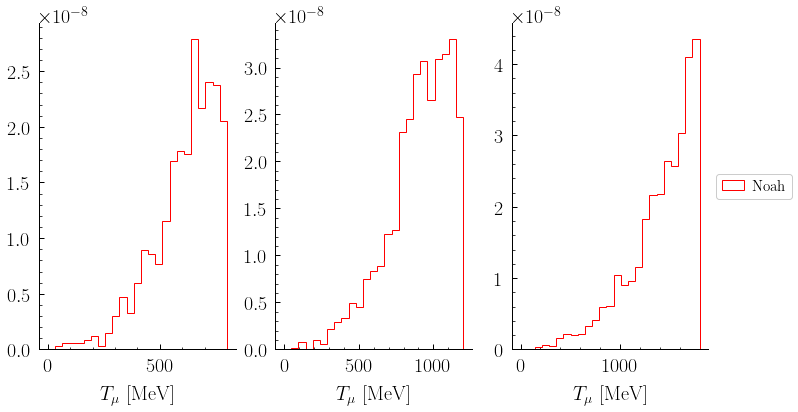

In [125]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i in range(0,3):


    ax[i].hist(flux_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(flux_dsig[i])*flux_weights[i],histtype='step',color='red',label='Noah')


      
    #ax[i].set_xlim(omegalows[i],omegahighs[i])
    ax[i].set_xlabel(r'$T_{\mu}$ [MeV]')
    ax[i] = fix_ax(ax[i])
    
#ax[0].set_ylabel(r'$\frac{d\sigma}{d$T_{\mu}$ d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
#ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
#ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
#ax[2].set_title(r'$\theta_{\mu} = {30}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

#fig.suptitle(r'$E_{\nu} = 1$ GeV')
plt.show()

(array([  13.,   36.,   44.,   84.,  165.,  219.,  263.,  363.,  443.,
         549.,  618.,  742.,  838.,  899.,  999., 1062., 1063., 1059.,
        1141., 1140., 1157., 1183., 1190., 1174., 1224., 1221., 1199.,
        1214., 1167., 1250., 1140., 1189., 1056., 1082., 1011.,  967.,
         868.,  879.,  813.,  819.,  712.,  662.,  619.,  623.,  580.,
         536.,  419.,  405.,  380.,  334.,  316.,  248.,  223.,  164.,
         116.,   71.,   43.,    7.]),
 array([ 243.03777169,  359.22673529,  475.4156989 ,  591.60466251,
         707.79362611,  823.98258972,  940.17155333, 1056.36051693,
        1172.54948054, 1288.73844414, 1404.92740775, 1521.11637136,
        1637.30533496, 1753.49429857, 1869.68326218, 1985.87222578,
        2102.06118939, 2218.25015299, 2334.4391166 , 2450.62808021,
        2566.81704381, 2683.00600742, 2799.19497103, 2915.38393463,
        3031.57289824, 3147.76186184, 3263.95082545, 3380.13978906,
        3496.32875266, 3612.51771627, 3728.70667988, 3844.89

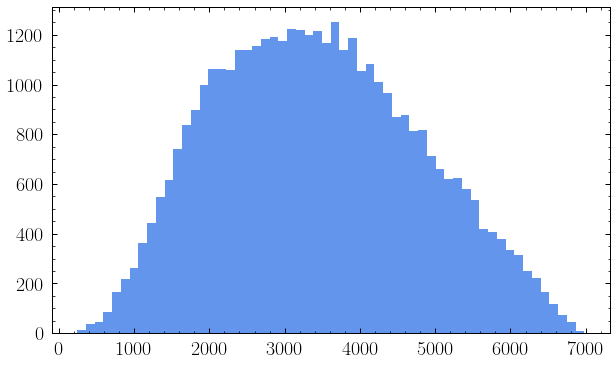

In [128]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

flux_df = pd.read_csv('/Users/noah/Physics/Fermilab/Event_Generator/flux_fold/flux_nu_noheader.dat',sep="\s+|\t+|\s+\t+|\t+\s+",header=None, engine='python')

flux_df.columns = ['Elo','Ehigh','numu', 'numub', 'nue', 'nueb']

weight = 1./(5000./100.)

ax.hist(np.array(flux_probe_p4)[:,0],bins="auto")

#ax.plot(1000.*(flux_df['Elo'] + flux_df['Ehigh'])/2, flux_df['numu']/2.5967881461245138E-011,linestyle='dotted',color='red',linewidth=2.5)
#ax.set_xlim([0,3000])
#ax.set_ylim([0,2.0])

In [71]:
highE_probe_p4 = []
highE_lepton_p4 = []
highE_innuc_p4 = []
highE_outnuc_p4 = []

with open('C12_CC_20000.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        highE_probe_p4.append(p1)
        highE_lepton_p4.append(p2)
        highE_innuc_p4.append(p3)
        highE_outnuc_p4.append(p4)

In [76]:
highE_genie_xsec = 4.51393e-05
highE_genie_numevents = 300000

#Get GENIE events

highE_genie_file = uproot.open("/Users/noah/Desktop/C12_20GeV.gst.root")
highE_gst = genie_file["gst"]
highE_branches = gst.arrays()
highE_genie_probe_p4 = np.transpose([branches['Ev'],branches['pxv'], branches['pyv'], branches['pzv']])*1.e3
highE_genie_lepton_p4 = np.transpose([branches['El'],branches['pxl'], branches['pyl'], branches['pzl']])*1.e3
highE_genie_neutron_p4 = np.transpose([branches['En'],branches['pxn'], branches['pyn'], branches['pzn']])*1.e3
highE_genie_proton_p4 = np.transpose([branches['Ei'][branches['pdgi'] == 2212],branches['pxi'][branches['pdgi'] == 2212], branches['pyi'][branches['pdgi'] == 2212], branches['pzi'][branches['pdgi'] == 2212]])*1.e3

Noahs highE mean=  5.086102985220326
Noahs mean =  -14.267701593893241
Achilles mean =  -17.64681489372548
GENIE mean =  -15.704810453095687
GENIE highE mean =  -15.704810453095687


Text(67.3043737352117, 0.5, '$\\frac{d\\sigma}{dP_{N_{L}}}$ [nb/MeV]')

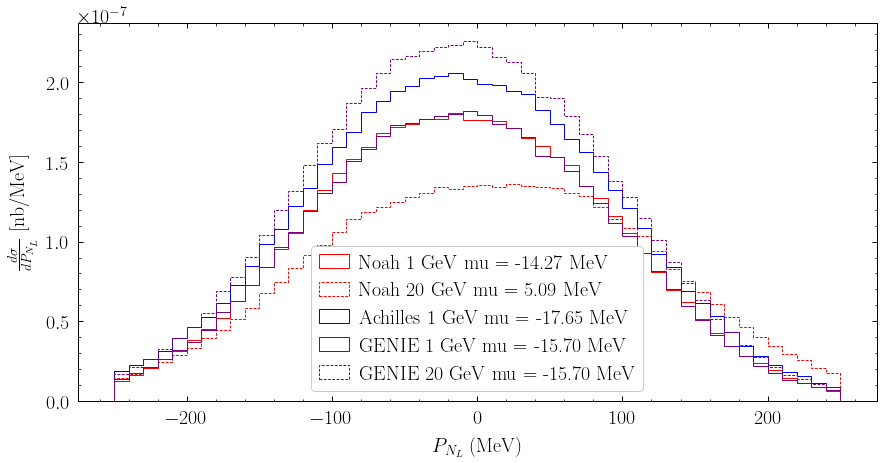

In [77]:
#Look at longitudinal nucleon momentum
#interesting we observe the same shift as https://arxiv.org/pdf/2310.15633.pdf
fig,ax = plt.subplots(1,1,figsize=(12,6))
fig.tight_layout()

from scipy.stats import norm
noah_long_highE = parallel_mom(highE_probe_p4,highE_innuc_p4)
noah_long = parallel_mom(probe_p4,innuc_p4)
Ac_long = parallel_mom(Ac_probe_p4,Ac_neutron_p4)
genie_long = parallel_mom(genie_probe_p4,genie_neutron_p4)
genie_long_highE = parallel_mom(highE_genie_probe_p4,highE_genie_neutron_p4)


noah_mean_HighE,noah_std_HighE=norm.fit(noah_long_highE)
print('Noahs highE mean= ',noah_mean_HighE)
noah_mean,noah_std=norm.fit(noah_long)
print('Noahs mean = ',noah_mean)
achilles_mean,noah_std=norm.fit(Ac_long)
print('Achilles mean = ',achilles_mean)
genie_mean,noah_std=norm.fit(genie_long)
print('GENIE mean = ',genie_mean)
genie_mean_HighE,noah_std=norm.fit(genie_long_highE)
print('GENIE highE mean = ',genie_mean_HighE)

noah_xsec_HighE = 4.4418e-05

ax.hist(noah_long, bins = 50, range = (-250,250), weights = np.ones_like(noah_long)*noah_xsec/noah_numevents/10.,histtype='step',label='Noah 1 GeV mu = {:.2f} MeV'.format(noah_mean),color='red')

ax.hist(noah_long_highE, bins = 50, range = (-250,250), weights = np.ones_like(noah_long_highE)*noah_xsec_HighE/noah_numevents/10.,histtype='step',label='Noah 20 GeV mu = {:.2f} MeV'.format(noah_mean_HighE),color='red',linestyle='--')

ax.hist(Ac_long, bins = 50, range = (-250,250), weights = np.ones_like(Ac_long)*achilles_xsec/achilles_numevents/10.,histtype='step',label='Achilles 1 GeV mu = {:.2f} MeV'.format(achilles_mean),color='blue')

ax.hist(genie_long, bins = 50, range = (-250,250), weights = np.ones_like(genie_long)*genie_xsec/genie_numevents/10.,histtype='step',label='GENIE 1 GeV mu = {:.2f} MeV'.format(genie_mean),color='purple')

ax.hist(genie_long_highE, bins = 50, range = (-250,250), weights = np.ones_like(genie_long_highE)*highE_genie_xsec/highE_genie_numevents/10.,histtype='step',label='GENIE 20 GeV mu = {:.2f} MeV'.format(genie_mean_HighE),color='purple',linestyle='--')

ax.legend()

ax.set_xlabel(r'$P_{N_{L}}$ (MeV)')
ax.set_ylabel(r'$\frac{d\sigma}{dP_{N_{L}}}$ [nb/MeV]')

In [3]:
#Get Noah's events

#Useful constants
tm15fm2_to_nb = 1.e-8
tm38cm2_to_nb = 1.
GeVm2_to_nb = 389379.09

#GENIE total cross section
noah_xsec =  150071.28326165327#nb

noah_numevents = 400001

probe_p4 = []
lepton_p4 = []
innuc_p4 = []
outnuc_p4 = []

with open('/Users/noah/Physics/Fermilab/Event_Generator/EM/C12_EM_p_730.out', 'r') as file:
    #total_xsec_line = file.readline()
    for p1,p2,p3,p4 in itertools.zip_longest(*[file]*4):
       # print(p1)
        p1 = [float(x) for x in p1.split()]
        p2 = [float(x) for x in p2.split()]
        p3 = [float(x) for x in p3.split()]
        p4 = [float(x) for x in p4.split()]
        probe_p4.append(p1)
        lepton_p4.append(p2)
        innuc_p4.append(p3)
        outnuc_p4.append(p4)

In [8]:
numbins = 25
omegalows = [30,30,30]
omegahighs = [200,250,350]

dtheta = 1.0
angles = [18,25,37.1]

noah_dsig,noah_weights = get_double_diff_xsec(probe_p4, lepton_p4, angles, dtheta, noah_xsec, noah_numevents, numbins, omegalows, omegahighs)


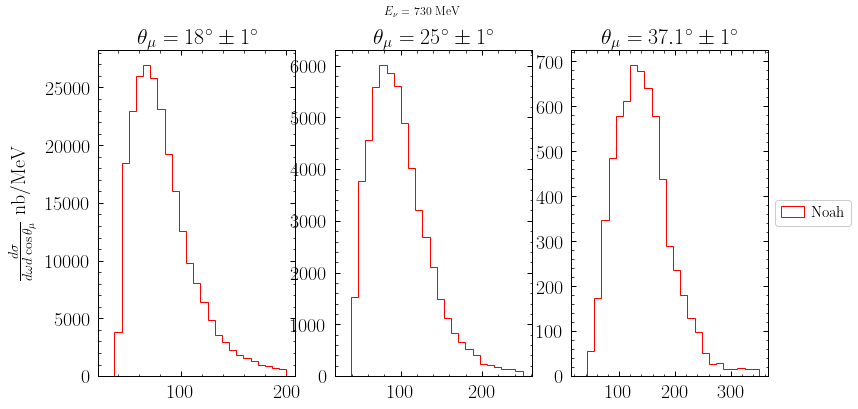

In [9]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i,angle in enumerate(angles):

    ax[i].hist(noah_dsig[i], bins=numbins, range=(omegalows[i],omegahighs[i]),weights=np.ones_like(noah_dsig[i])*noah_weights[i],histtype='step',color='red',label='Noah')

    
ax[0].set_ylabel(r'$\frac{d\sigma}{d\omega d\cos\theta_{\mu}}$ $\rm{nb}/\rm{MeV}$')
        
ax[0].set_title(r'$\theta_{\mu} = {18}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[1].set_title(r'$\theta_{\mu} = {25}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].set_title(r'$\theta_{\mu} = {37.1}^{\circ}\pm 1^{\circ}$',fontsize=22)
ax[2].legend(loc='center left',bbox_to_anchor=(1.0,0.5), prop={'size': 15})

fig.suptitle(r'$E_{\nu} = 730$ MeV')
plt.show()